In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.layers import *
import random

In [2]:
HEIGHT,WIDTH = 105,105
CHANNELS = 3

path_ls = []
train_path = "../input/vggface-using-tripletloss/crop_faces/faces"
label_dir = {}
NUM_CLASSES = 20
NUM_IMAGES_PER_CLASS = 5

for i,folder in enumerate(os.listdir(train_path)[:NUM_CLASSES]):
    label_dir[folder] = i+1
    dir_path = os.path.join(train_path,folder)
    for img in os.listdir(dir_path)[:NUM_IMAGES_PER_CLASS]:
        path_ls.append(os.path.join(dir_path,img))

path_df = pd.Series(path_ls)
path_df.to_csv("./paths.csv")

random.seed(143)        
random.shuffle(path_ls)

In [3]:
def filepath_to_arr(filepath,SHAPE = (HEIGHT,WIDTH)):
    img = tf.keras.preprocessing.image.load_img(filepath,target_size=SHAPE)
    arr = tf.keras.preprocessing.image.img_to_array(img)/255.
    return arr

def train_data(path_ls):
    label_arr = []
    img_arr = []
    for path1 in path_ls:
        for path2 in path_ls:
            name1 = path1.split("/")[-2]
            name2 = path2.split("/")[-2]
            if label_dir[name1] == label_dir[name2]:
                label_arr.append(1.)
            else:
                label_arr.append(0.)
                
            img1 = filepath_to_arr(path1)
            img1 = np.expand_dims(img1,axis=-1)
            img2 = filepath_to_arr(path2)
            img2 = np.expand_dims(img2,axis=-1)
            arr = np.concatenate([img1,img2],axis=-1)
            img_arr.append(arr)
    return img_arr,label_arr

img_arr,label_arr = train_data(path_ls)
img_arr,label_arr = np.array(img_arr),np.array(label_arr)

In [4]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
SPLIT = int(0.9*img_arr.shape[0])

train_arr,train_label = img_arr[:SPLIT],label_arr[:SPLIT]
val_arr,val_label = img_arr[SPLIT:],label_arr[SPLIT:]

In [5]:
def create_model():
    inputs = tf.keras.Input(shape = (HEIGHT,WIDTH,CHANNELS,2,))
    
    input_a = inputs[:,:,:,:,0]
    input_b = inputs[:,:,:,:,1]
   

    embed_model = tf.keras.Sequential([
        tf.keras.Input(shape = (HEIGHT,WIDTH,CHANNELS,)),
        Conv2D(filters=64, kernel_size=10, padding='valid'),
        BatchNormalization(),
        ReLU(),
        MaxPool2D((2, 2)),

        Conv2D(filters=128, kernel_size=7, padding='valid'),
        BatchNormalization(),
        ReLU(),
        MaxPool2D((2, 2)),

        Conv2D(filters=128, kernel_size=4, padding='valid'),
        BatchNormalization(),
        ReLU(),
        MaxPool2D((2, 2)),
        
        Conv2D(filters=256, kernel_size=4, padding='valid'),
        BatchNormalization(),
        ReLU(),

        Flatten(),
    ])
    
    embed_a = embed_model(input_a)
    embed_b = embed_model(input_b)
    
    l1_layer = Lambda(lambda tensors:tf.math.abs(tensors[0] - tensors[1]))
    l1_distance = l1_layer([embed_a,embed_b])
    
    outputs = Dense(1,activation="sigmoid")(l1_distance)
    
    model = tf.keras.Model(inputs,outputs)
    
    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 3, 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 105, 105, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 105, 105, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 9216)         1209920     tf.__operators__.getitem[0][0]   
                                                                 tf.__operators__.getitem_1[0]

In [6]:
def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.BinaryCrossentropy()
        
    metrics = [
       tf.keras.metrics.AUC(name='acc')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [7]:
def create_callbacks():
    
    cpk_path = './best_model.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_acc',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_acc',
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

In [8]:
EPOCHS= 10


with tf.device('/device:GPU:0'):
    
    model = create_model()
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks()
    
    history = model.fit(x = train_arr,
                        y=train_label, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = (val_arr,val_label),
                        verbose=1)

Epoch 1/10
282/282 [==============================] - 19s 50ms/step - loss: 0.2126 - acc: 0.6909 - val_loss: 0.1762 - val_acc: 0.7676

Epoch 00001: val_acc improved from -inf to 0.76759, saving model to ./best_model.h5
Epoch 2/10
282/282 [==============================] - 13s 46ms/step - loss: 0.1327 - acc: 0.8948 - val_loss: 0.1368 - val_acc: 0.9069

Epoch 00002: val_acc improved from 0.76759 to 0.90686, saving model to ./best_model.h5
Epoch 3/10
282/282 [==============================] - 13s 47ms/step - loss: 0.0982 - acc: 0.9694 - val_loss: 0.1138 - val_acc: 0.9386

Epoch 00003: val_acc improved from 0.90686 to 0.93861, saving model to ./best_model.h5
Epoch 4/10
282/282 [==============================] - 13s 46ms/step - loss: 0.0545 - acc: 0.9923 - val_loss: 0.0852 - val_acc: 0.9803

Epoch 00004: val_acc improved from 0.93861 to 0.98026, saving model to ./best_model.h5
Epoch 5/10
282/282 [==============================] - 13s 46ms/step - loss: 0.0364 - acc: 0.9989 - val_loss: 0.0516

In [9]:
path_ls.sort()
train_folders = [x.split("/")[-2] for x in path_ls]

test_ls = []

for f in os.listdir(train_path):
    path_a = os.path.join(train_path,f)
    filename = os.listdir(path_a)[-1]
    test_ls.append(os.path.join(path_a,filename))
    
train_folders = set(train_folders)

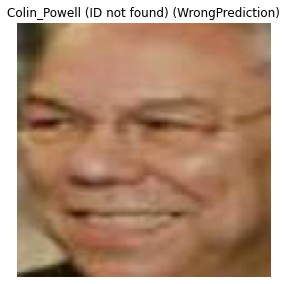

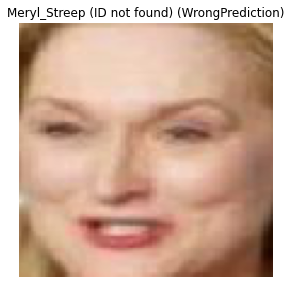

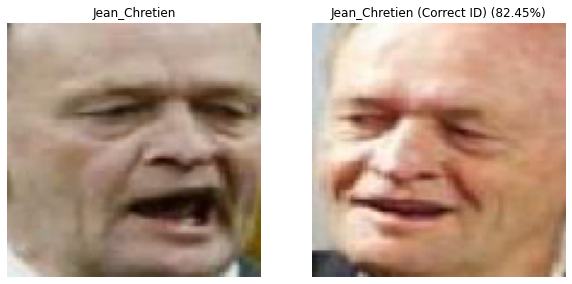

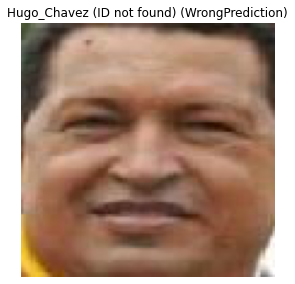

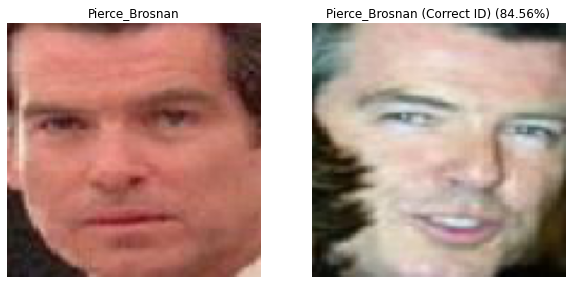

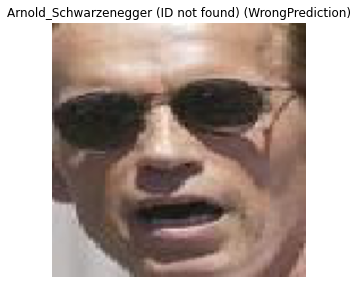

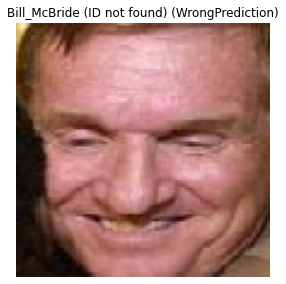

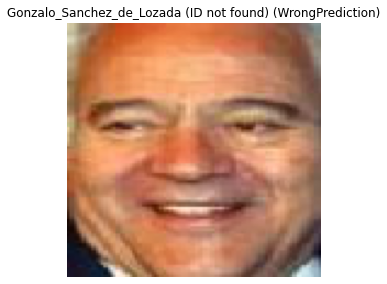

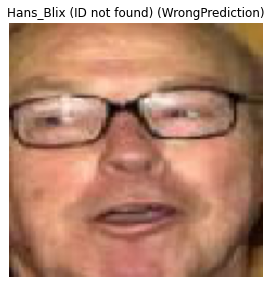

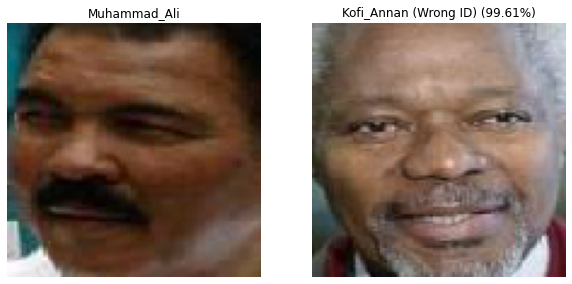

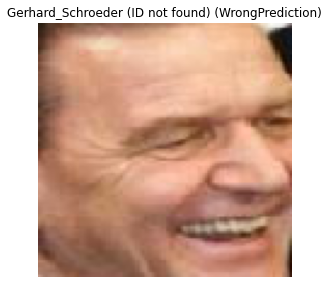

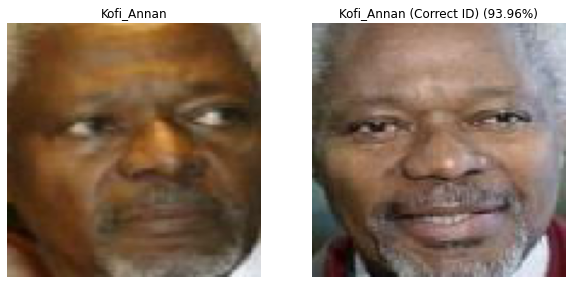

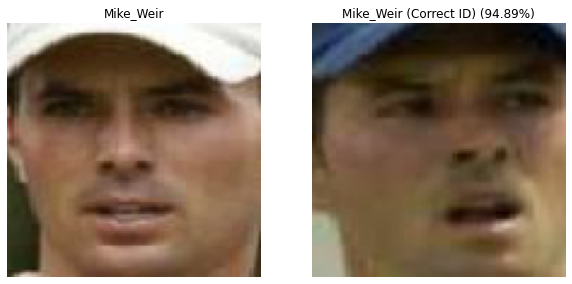

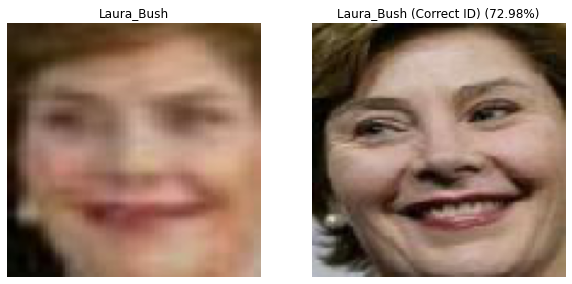

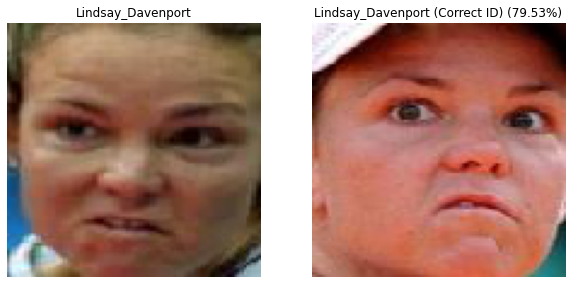

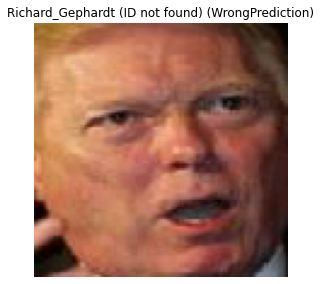

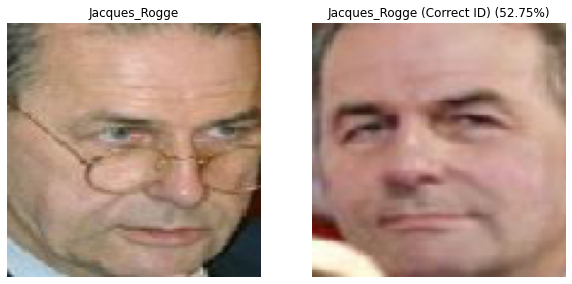

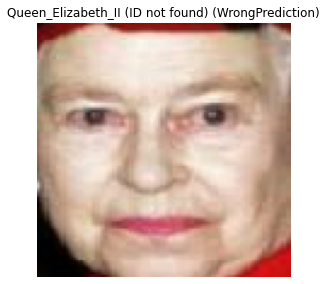

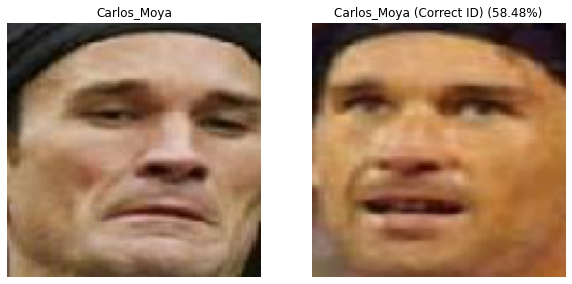

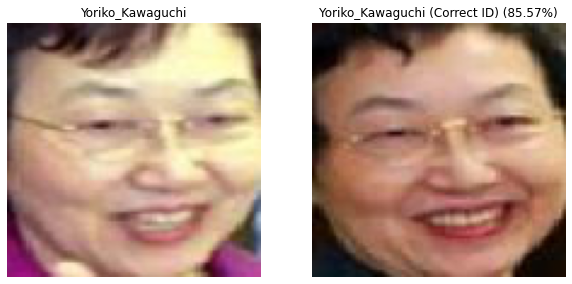

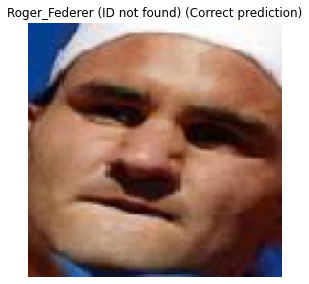

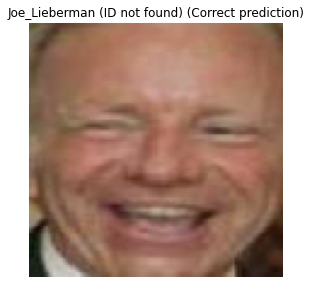

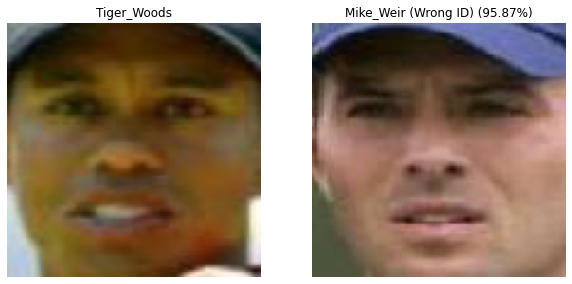

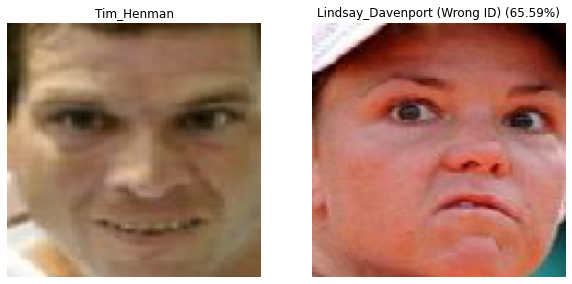

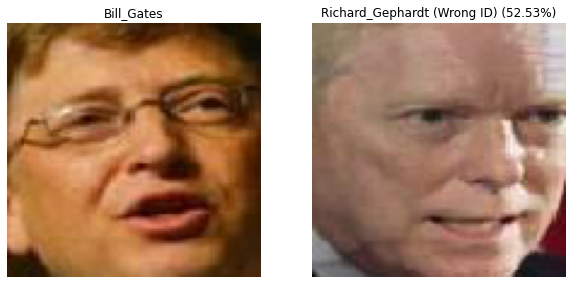

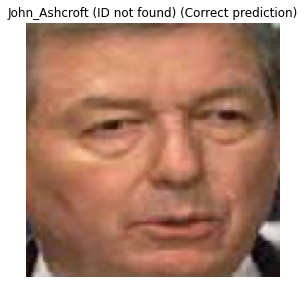

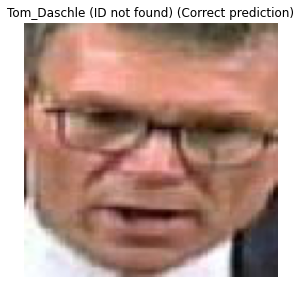

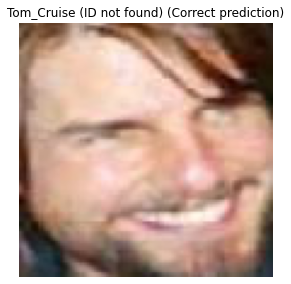

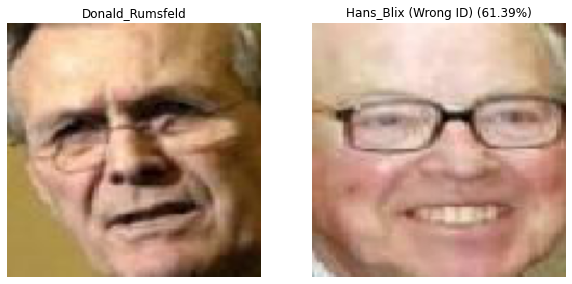

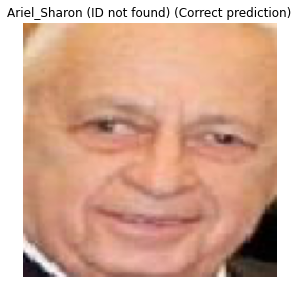

In [10]:
THRESHOLD = 50.00

pred_id = {}
test_ls = test_ls[:30]


for path1 in test_ls:
    test_name = path1.split("/")[-2]
    max_pred = -100
    max_name = ""
    arr1 = filepath_to_arr(path1)
    
    for path2 in path_ls:
        arr2 = filepath_to_arr(path2)
        test_arr = np.concatenate([np.expand_dims(arr1,axis=-1),np.expand_dims(arr2,axis=-1)],axis=-1)
        test_arr = np.expand_dims(test_arr,axis=0)
        pred = model.predict(test_arr)
        pred = round(pred[0][0]*100,2)
        train_name = path2.split("/")[-2]
        if pred > max_pred and pred > THRESHOLD:
            max_pred = pred
            max_name = train_name
            max_arr = arr2
   
        
    plt.figure(figsize=(10,10*len(test_ls))) 
    if max_name != "":
        plt.subplot(len(test_ls),2,1)
        plt.imshow(arr1)
        plt.axis("off")
        plt.title(test_name)
        plt.subplot(len(test_ls),2,2)
        plt.imshow(max_arr)
        plt.axis("off")
        if test_name == max_name:
            pred_id[test_name] = 1
            text = max_name + " (Correct ID) ("+str(max_pred) +"%)"
        else:
            pred_id[test_name] = 0
            text = max_name + " (Wrong ID) ("+str(max_pred) +"%)" 
        plt.title(text)
    else:
        plt.subplot(len(test_ls),2,1)
        plt.imshow(arr1)
        plt.axis("off")
        if test_name in train_folders:
            pred_id[test_name] = 0
            plt.title(test_name+" (ID not found) (WrongPrediction)") 
        else:
            pred_id[test_name] = 1
            plt.title(test_name+" (ID not found) (Correct prediction)")
    plt.show()

In [11]:
corr_pred = sum(list(pred_id.values()))
print("Total: ",len(test_ls)," Correctly predicted: ",corr_pred)

Total:  30  Correctly predicted:  15
